## Random Numbers and Sampling

I love statistics and frequently code up neat models and tests in my free time and at work. It's amazing the tools that are at my finger tips when I build models in scala, java, python, etc. However, it's always bothered me...how do these tools work at a fundamental level? 

For example, then I code up a metropolis sampler in python using the numpy/scipy stats packages, how does numpy/scipy sample from all of the weird distributions that they support? Well, in this blog post I'm going to cover the fundamental concepts of how computers handle randomness. We'll start with how computers generate "random" numbers and then discuss how these random numbers can be used to sample a variety of complex probability distributions.

**Content Overview:**
* **Fake it till you make it:** Computer Generated Randomness
* **Throwback Thursday:** Remembering Probability Distributions
* **Putting on the uniform:** Turning Uniform Distributions Into Anything and Everything

### Fake it till you make it: Computer Generated Randomness

Generating a random number is a lot like growing a tree; it starts with a seed. It turns out that computers can't generate truely random events. Therefore we need to try and fake randomness. We can fake randomness using pseudo random number generators (rngs). Rngs are functions that take in numbers and transform them into other numbers in a process that fakes randomness. The numbers that go into the rng are called seeds while the outputs are "random" numbers. These functions are deterministic so that the same seed will always generate the same "random" number. This can be useful when we want to add some level of replicability to a stochastic process. 

For example, we might want to replicate a bootsrtap training rpocess with decision trees. We can do this by fixing the random seed that the boostrap process to "randomly" sample the training data. This is trivial in numpy, scipy, tensorflow and almost all typical math/stats packages. 

A greate example of rngs comes from classic video games! In fact the rng we are about to build is based on the rng used by [Super Mario World](https://www.youtube.com/watch?v=q15yNrJHOak). These rngs add randomness to the game that make every play through slightly different. The rng can be used to change enemy attack patterns, the success chances of actions, or the rewards gained from loot boxes. Classic games were hardware constrained (low memory and poor computation power) and so used very simple rngs (which is why we are starting there).

Ok, let's build our first rng! It will take in 2 16bit numbers (our two seeds) and output one "random" 32bit number. This means that we will mimic sampling a uniform dsitribution from $0$ to $2^{32}$ (4,294,967,296 unique values!).

Before I go into the exact procedure, let's review some important bitwise operations. I know, you came here for stats talk not assembly operations...well, we're going to need these operations to build the generator so buck up. If you really don't care about the bitwise operations, skip down to the **TLDR**.

Let's define a few terms:

**ASL:** [Arithmatic Shift Left](https://en.wikipedia.org/wiki/Arithmetic_shift) <br>
Here we shift one bit of our number left one position (basically doubles the original number). The shifted bit goes into a "carry" flag.

Original: 01000010 (binary) 42 (hex) <br>
ASL: 10000100 (binary) 84 (hex) => 0 bit added to carry flag

**BIT:** [Bit Test](https://en.wikipedia.org/wiki/Bit_Test) <br>
If accumulator and operator equal zero then a z flag is set to 1.

Accumulator: 10010010 (binary) 92 (hex) <br>
Operator: 00100101 (binary) 25 (hex) <br>
Result: 00000000 (binary) 00 (hex) => z flag set to 1

**EOR:** [Exclusive Or](https://en.wikipedia.org/wiki/Exclusive_or) <br>
Flips the bits in operand one where the bits in operand two are set. 

Operand One: 11010110 (binary) D6 (hex) <br>
Operand Two: 10001100 (binary) 8C (hex) <br>
Result: 01011010 (binary) 5A (hex) <br>

Here is the rng:
1. Take seed one and ASL twice to get result one.
2. Add seed one, result one, and the carry flag to get result two.
3. Take seed two and ASL once. 
4. BIT the shifted seed two with constant 20. 
5. Depending on the z and c flags (updated as needed by ASL and BIT) we may update seed two. 
6. EOR result two with the updated seed two. This represents the first half of the random output. 
7. Rinse and repeat the above with the updated seed one and seed two to get the second half of the output. 

This can be hard to visualize. You can see an animation of this process in this youtube video: [Super Mario World - Random Number Generation
](https://www.youtube.com/watch?v=q15yNrJHOak). I recommend watching at 50% speed as it goes by rather quick. 

**TLDR:** This whole operation _basically_ multiplies one seed by 5 and then adds one. The second seed is doubled. If the 4th and 7th bits of the updated second seed are the same than add one. 

We use 16bit numbers for our seeds so with a fixed list of seeds, like that used in the original Super Mario World, we would see the rng repeat numbers after cycling through 526838144 successive calls. 

Ok, enough talk, let's build this rng!

In [2]:
def extract_bit(value, n):
    """Extract the n'th bit, and move back to 0 position."""
    return (value >> (n-1)) & 1 

def update_seeds(S, T):
    """Generates the next two seeds"""
    return (5 * S + 1), (2 * T + (extract_bit(T, 11) == extract_bit(T, 16)))

def get_rand(S,T):
    """Generate Pseudo Random 32bit Number from 2 16bit Seeds"""
    S, T = update_seeds(S, T)
    S = S & 0xffff
    T = T & 0xffff
    K = S ^ T

    S, T = update_seeds(S, T)
    S = S & 0xffff
    T = T & 0xffff
    J = S ^ T

    return int("{:016b}{:016b}".format(K, J), 2)

In [3]:
S, T = 396, 86947
get_rand(S,T)

2700765245

A big thanks to [holroy](https://codereview.stackexchange.com/questions/162542/pseudo-random-number-generator) for the nice python implementation above.

Now, Super Mario World had a fixed list of seed values (S,T) that it cycled through to get random numbers. As mentioned before, this can be nice when we want to add replicability to a stochastic program we are writing, but sometimes we want a bit more randomness. 

There are a few ways we could make our rng more random (or even truely random!). Some security firms use the [fluid motion in lava lamps](https://en.wikipedia.org/wiki/Lavarand) to generate random seeds. You could also roll die or sample noise outside of the ionosphere (noise inside the ionosphere isn't always truely random and is heavily influenced by radio waves). 

We'll use a bit more of a hacky solution and assume that the millisecond of the timestamp at which the rng is called is truely random. This might not be the case if the function is called many time in quick succession...but it's good enough for government work! (an old joke we used to say in the lab)

In [4]:
import datetime

def sample_16bit():
    x = datetime.datetime.now().time().microsecond
    while x > 2**16:
        x = datetime.datetime.now().time().microsecond
    return int(x)

Let's put it all together. To make sure we are actually approximating something like a random uniform distribution, we'll take a ton of samples and plot the cummulative distribution function (cdf) and probability density function (pdf). I'll talk more about what the cdf and pdf are in the next section. For now, we just want to make sure that the cdf looks like a monotonically increasing like and the pdf looks flat.

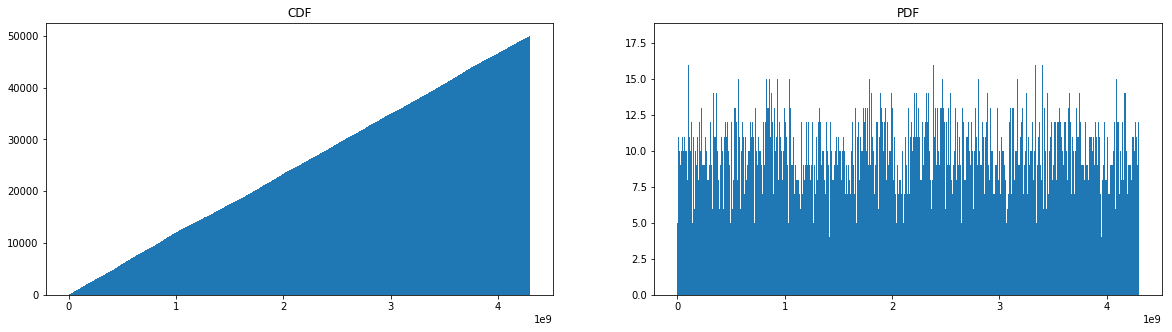

In [20]:
import matplotlib.pyplot as plt

trace = []
for i in range(50000):
    S = sample_16bit()
    T = sample_16bit()
    trace.append(get_rand(S,T))
    
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(trace,bins=5000,cumulative=True)
plt.title('CDF')
plt.subplot(122)
plt.hist(trace,bins=5000)
plt.title('PDF')
plt.show()

Yay! The CDF looks exactly like we would expect and the pdf looks close enough to quite my conscience. It turns out that a lot of actual rngs (like those used by default in the linux system) use user actions to generate random numbers...but those are a bit more sophisticated than the method shown here. 

One big problem with this method is that it is predictable. If a hacker knew the exact time that a command was executed, they would know the random numbers generated. That knowledge could be used for all sorts of mischief. 

### Throwback Thursday: Remembering Probability Distributions

Before we continue to the next section, let's quickly review probability distributions. Probability distributions give us an understanding of the relative proabability of a set of events occuring. There are simple distributions that most people are familair with like the gaussian (normal) distribution. There are also more obscure distributions like the dirichlet distribution (a distribution over distributions useful for mixture modeling).

We start with probability mass functions (pmf). These represent the relative probability of discrete events occuring. For example, the probability over outcomes when rolling a (fair) dice. 

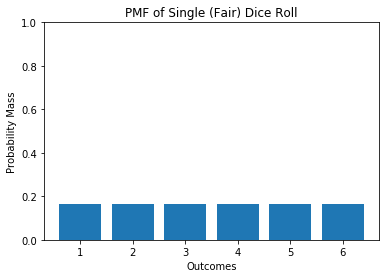

In [14]:
outcomes = [1,2,3,4,5,6]
probabilities = [1/6,1/6,1/6,1/6,1/6,1/6]
plt.bar(outcomes,probabilities)
plt.ylim(0,1.0)
plt.title("PMF of Single (Fair) Dice Roll")
plt.xlabel("Outcomes")
plt.ylabel("Probability Mass")
plt.show()

In the case that we have continuous valued outcomes we get a probability density function (pdf). For example, the probability of being a certain height given that you are male, caucasian, and grew up in the US. 

Sometimes these densities sum to 1.0 (or 100%). However, it's important to note that sometimes these densities are unnormalized and do not add up to 1.0. I won't go into detail about this, but one example is improper priors for bayesian inference. 

/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  if __name__ == '__main__':


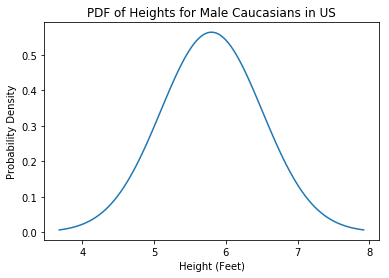

In [19]:
import matplotlib.mlab as mlab
import numpy as np
import math

mu = 5.8
variance = 0.5
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.title("PDF of Heights for Male Caucasians in US")
plt.xlabel("Height (Feet)")
plt.ylabel("Probability Density")
plt.show()

The cumulative dsitribution function (cdf) is the probability that a particular event OR and event of lower value will occur. In the case of a continuous random variable, it gives the area under the pdf from negative infinity up to the event value x.

/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  """Entry point for launching an IPython kernel.


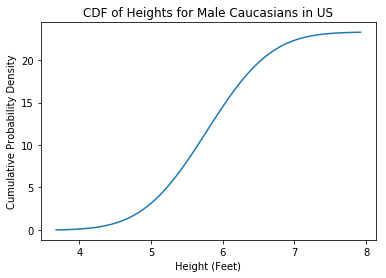

In [18]:
plt.plot(x,np.cumsum(mlab.normpdf(x, mu, sigma)))
plt.title("CDF of Heights for Male Caucasians in US")
plt.xlabel("Height (Feet)")
plt.ylabel("Cumulative Probability Density")
plt.show()

### Putting on the uniform: Turning Uniform Distributions Into Anything and Everything

In the first section we learned how to generate random samples from a uniform distribution. What if we want to sample a more complex distribution? 

We can sample from arbitrary functions using markov chain monte carlo (mcmc) sampling...but that is over kill in this situation. I'll leave MCMC as a topic for a future blog post (it's one of my favorite subjects tho!). Instead of mcmc, we're going to use the [inverse transform trick](http://www.pwills.com/blog/posts/2018/06/24/sampling.html). 

We can use the uniform distribution to sample from any function that we know the inverse cdf (also known as the quantile function) for. Let's start with the inverse cdf of the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution):

$F^{-1}(p)=\mu+\sigma \sqrt{2}erf^{-1}(2p-1)$

where erf is the [error function](https://en.wikipedia.org/wiki/Error_function).

We generate samples from the normal distribution by passing the uniform samples through the above function:

$X=F^{-1}(U)$

$U \sim Unif(0,1)$

We'll use the rng we built in section one with one modification. We want a uniform bounded at $0$ and $1$, not $0$ and $2^{32}$. We make the appropriate affine transformation to get the distribution we want in function `U()`. 

In [67]:
from scipy.special import erfinv
from scipy.stats import norm

def U():
    S = sample_16bit()
    T = sample_16bit()
    return get_rand(S,T) / 2**32

def sample_normal(mu=0.0,std=1.0):
    x = U()
    return mu + std*np.sqrt(2.0)*erfinv(2.0*x-1.0)
    #return norm.ppf(x,loc=mu,scale=std) # scipy has this built in

Let's test out our functions! We'll sample from: $X \sim \mathcal{N}(10,3)$

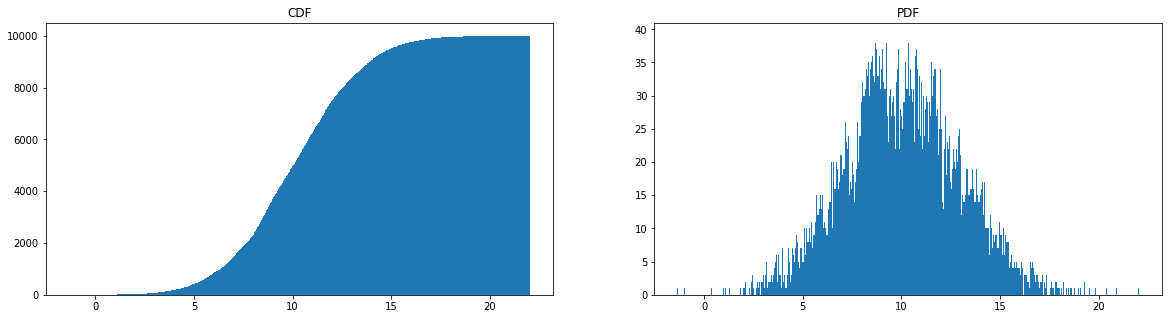

In [73]:
trace = []
for i in range(10000):
    trace.append(sample_normal(10,3))
    
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(trace,bins=1000,cumulative=True)
plt.title('CDF')
plt.subplot(122)
plt.hist(trace,bins=1000)
plt.title('PDF')
plt.show()

Why does the inverse cdf trick work? Well the cdf gives the probability of seeing the value x or smaller. The inverse cdf returns the value x that is associated with cdf probability p. So the inputs to the inverse cdf are probabilities $[0,1]$...you can see why sampling a uniform distribution 0 to 1 might be useful! You can dig deeper into why the inverse cdf is so useful [here](https://stats.stackexchange.com/questions/212813/help-me-understand-the-quantile-inverse-cdf-function).

So if you want to sample a function from scratch all you need is a way to calculate the inverse cdf! or at least to approximate the inverse cdf. For most popular distributions it is easy to look up the formula for the inverse cdf on wikipedia. For a simple example for approximating the inverse cdf with unknown form see [here](http://www.nehalemlabs.net/prototype/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/). If you really liked this tutorial and aren't willing to wait for my future blog post on mcmc and rejection sampling, this [article](http://people.duke.edu/~ccc14/sta-663-2016/15A_RandomNumbers.html) has a high level overview of a variety of sampling methodologies from the inverse transform trick up to rejection samples.

## Closing Remarks
Hopefully this post answered a few of your questions about how random numbers are generated! The concepts covered here were rather crude and high level, but they give a solid foundational look at how randomness and sampling are handled by actual stats packages. 

# P.S

After writing this original post I wanted to add a couple more thoughts. First, I'll cover a much simpler rng that might be useful to future readers. Secondly, I cover copula (which also make use of the inverse cdf trick).

First things first, a simple rng. This is the Linear congruential generators (LCG). We represent each new random number as $z_{i+1}$:

$z_{i+1}=(a*z_i+c) mod m$

where c and m are relatively prime, a−1 is divisible by all prime factors of m, and a−1 is a multiple of 4 if m is a multiple of 4. We need these constraints because the Hull-Dobell Theorem gaurantees that under these constraints LCG will then have a full period for all seeds. 

For LCG $z_0$ is the seed for the rng.

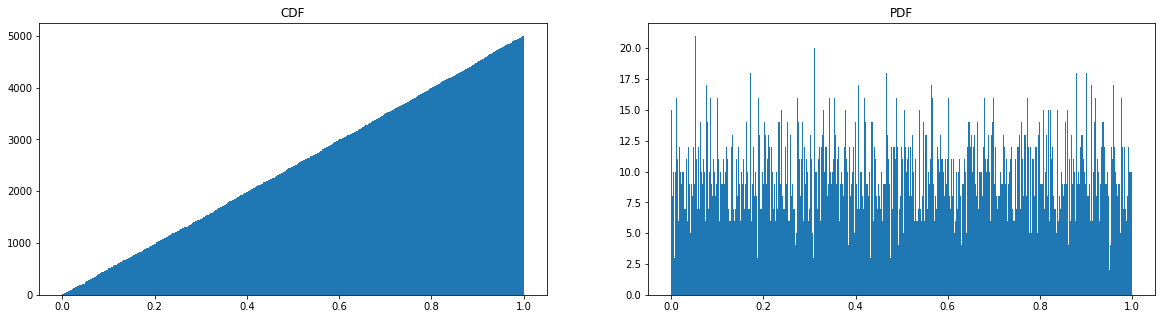

In [75]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a*rng.current + c) % m
    return rng.current/m

# setting the seed
rng.current = 1

trace = [rng() for i in range(5000)]
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(trace,bins=500,cumulative=True)
plt.title('CDF')
plt.subplot(122)
plt.hist(trace,bins=500)
plt.title('PDF')
plt.show()

Okay, now let's talk about copula! Copula are used to decompose joint probability distriutions into the marginal distributions that make it up. This can be helpful for a variety of reasons! This discussion of copula borrows heavily from [Thomas Wiecki's](https://twiecki.github.io/blog/2018/05/03/copulas/) blog post on visualizing copula. I love Wiecki's blog posts and encourage you to read through this one. 

For example, imagine that you are a financial institution building a risk model. This model wants to take into account the probability that a particular loan will default and the predicted loss of the loan. We might imagine that these two probability distributions are somehow linked and that it would be useful to model them together! The probability of charging off (defaulting) is a beta distribution while the amount of the loss might be a half normal. I won't dig too deeply into this example, but hopefully it appropriately motivates the sue case. 

Now to be clear, joint distributions where the marginals are independant are trivial to woerk with. You can just treat each marginal seperately and model them independantly. However, it is the case where there is correlation between the distributions that things start to heat up. THis is the goal, dealing with joint distributions which are correlated!

Here we are going to learn how to deal with such a strange joint distribution. First, a quick review of the original blog post above. We start with a uniform distribution.

In [76]:
from scipy import stats

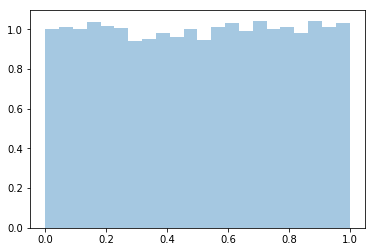

In [77]:
x = stats.uniform(0, 1).rvs(10000)
sns.distplot(x, kde=False, norm_hist=True)

Next we use the inverse transform trick to turn this uniform into a normal distribution. 

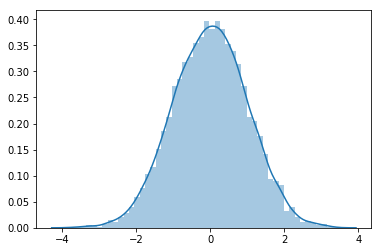

In [78]:
norm = stats.distributions.norm()
x_trans = norm.ppf(x) # inverse transform
sns.distplot(x_trans)

We can actually see this transformation by plotting the joint distribution of the uniform and gaussian distributions!

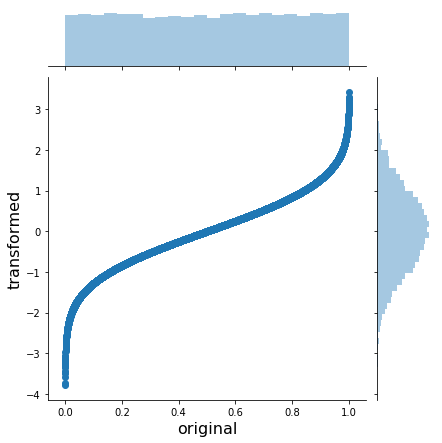

In [79]:
h = sns.jointplot(x, x_trans, stat_func=None)
h.set_axis_labels('original', 'transformed', fontsize=16);

Of course, we can always reverse this transformation by using the reverse of the reverse cdf! Also know as the cdf...

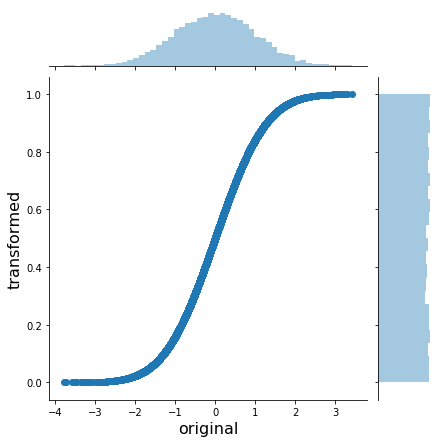

In [80]:
x_trans_trans = norm.cdf(x_trans)
h = sns.jointplot(x_trans, x_trans_trans, stat_func=None)
h.set_axis_labels('original', 'transformed', fontsize=16);

This has just been a review of transforming distributions to and from the uniform distribution. Now for the exciting stuff! Let's generate some correlated joint distributions.

Doing this is actually not horribly difficult. We start with a multivariate gaussian that has the correlation structure that we desire. We then map those gaussians into uniform distributions. Finally we transform those uniforms into whatever we want! The unfirm becomes our universal distribution translator. 

In [82]:
# define the means and covariance/correlations structure
means = [0, 0]
cov = [[1., 0.5],[0.5, 1.]]
# create our multivariate gaussian
mvnorm = stats.multivariate_normal(mean=means, cov=cov)
# Generate random samples from multivariate gaussian
x = mvnorm.rvs(100000)

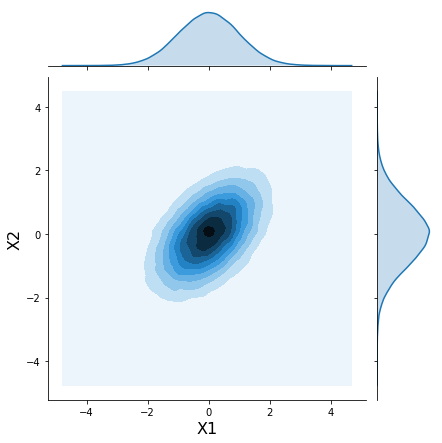

In [83]:
# visualize this manufacture joint normal
h = sns.jointplot(x[:, 0], x[:, 1], kind='kde', stat_func=None)
h.set_axis_labels('X1', 'X2', fontsize=16)

In [85]:
norm = stats.norm()
# transform the normal marginals to uniform marginals
x_unif = norm.cdf(x)

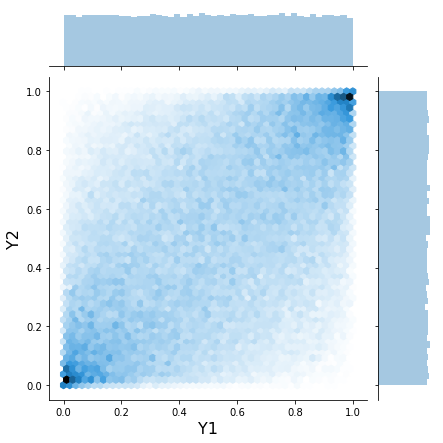

In [86]:
# plot the new joint distributions
h = sns.jointplot(x_unif[:, 0], x_unif[:, 1], kind='hex', stat_func=None)
h.set_axis_labels('Y1', 'Y2', fontsize=16);

We can now transform the marginals of this distribution into wahtever we want! let's try for the beta-halfnormal discussed in the motivating exmample. 

In [97]:
# define our new marginals
m1 = stats.halfnorm(0,1000)
m2 = stats.beta(a=10, b=2)
# transform our joint distribution
x1_trans = m1.ppf(x_unif[:, 0])
x2_trans = m2.ppf(x_unif[:, 1])

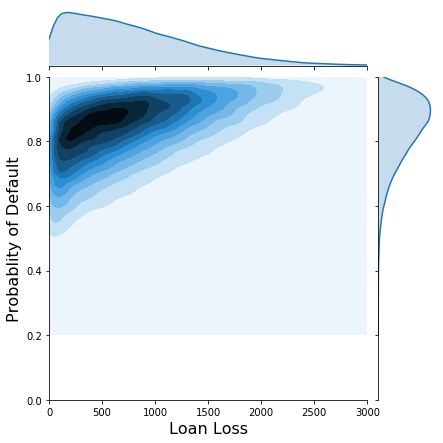

In [99]:
# plot the new joint distribution
h = sns.jointplot(x1_trans, x2_trans, kind='kde', xlim=(0, 3000), ylim=(0, 1.0), stat_func=None)
h.set_axis_labels('Loan Loss', 'Probablity of Default',  fontsize=16)